In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import freqz, resample
from speaker_calibration.sound import fft_welch

In [ ]:
# Parameters
path_str = r"C:/Users/RenartLab/Desktop/cdc-speaker-calibration/output/250819_142853"
path = Path(path_str)
chirp_duration = 10
noise_duration = 10
fs_sc = 192000
fs_adc = 250000
time_cons = 0.005
reference_pressure = 0.00002

## EQ Filter

In [ ]:
eq_filter = np.load(path / "inverse_filter.npy")
freq, response = freqz(eq_filter, 1, fs=fs_sc)
plt.plot(freq, 20 * np.log10(response))

plt.xlim(0, 40000)
plt.ylim(-60, 20)

## Calibration Sounds Frequency Spectrum

(0.0, 30000.0)

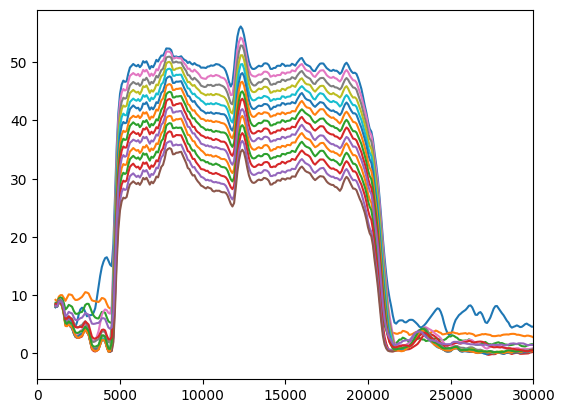

In [ ]:
# Define the file pattern
file_pattern = "/sounds/calibration_sound_{number}_rec.npy"

# Find all files that match the pattern
files = glob.glob(path_str + file_pattern.format(number="*"))

# Loop through the files and read them into numpy arrays
for file in files:
    noise = np.load(file)
    noise = resample(noise[:, 1], int(noise_duration * fs_sc))
    freq, fft = fft_welch(noise, fs=fs_sc, time_cons=time_cons)

    fft = fft[freq > 1000]
    freq = freq[freq > 1000]
    plt.plot(freq, 20 * np.log10(fft / reference_pressure))

plt.xlim(0, 30000)

In [ ]:
calibration = np.load(path / "calibration_parameters.npy")
calibration